# New York City Taxi Trip Duration

## 1. Постановка задачи

## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection


Прочитаем наш файл с исходными данными:

In [70]:
taxi_data = pd.read_csv("data/train.csv")
print(f'Train data shape: {taxi_data.shape}')
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведём признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определим временные рамки (без учета времени), за которые представлены данные.

In [71]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

start_date = taxi_data['pickup_datetime'].min().strftime('%Y-%m-%d')
end_date = taxi_data['pickup_datetime'].max().strftime('%Y-%m-%d')
print(f'Временные рамки {start_date} по {end_date}')


Временные рамки 2016-01-01 по 2016-06-30


In [72]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  object        
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 122.4+ MB


### Задание 2.2
Посмотрим на пропуски. 
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)

In [73]:
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков. 

а) Сколько уникальных таксопарков присутствует в данных

б) Каково максимальное количество пассажиров

в) Чему равна средняя и медианная длительность поездки

г) Чему равно минимальное и максимальное время поездки (в секундах)


In [74]:
display(taxi_data.describe().round())

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.0,1458644.0,1458644.0,1458644.0,1458644.0,1458644.0,1458644.0
mean,2.0,2.0,-74.0,41.0,-74.0,41.0,959.0
std,0.0,1.0,0.0,0.0,0.0,0.0,5237.0
min,1.0,0.0,-122.0,34.0,-122.0,32.0,1.0
25%,1.0,1.0,-74.0,41.0,-74.0,41.0,397.0
50%,2.0,1.0,-74.0,41.0,-74.0,41.0,662.0
75%,2.0,2.0,-74.0,41.0,-74.0,41.0,1075.0
max,2.0,9.0,-61.0,52.0,-61.0,44.0,3526282.0


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


### Задание 2.4
Реализуем функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.

а) Сколько поездок было совершено в субботу

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [75]:
def add_datetime_features(taxi_data):
    # Добавление столбца 'pickup_date' (дата без времени)
    taxi_data['pickup_date'] = pd.to_datetime(taxi_data['pickup_datetime']).dt.date
    # Добавление столбца 'pickup_hour' (час)
    taxi_data['pickup_hour'] = pd.to_datetime(taxi_data['pickup_datetime']).dt.hour
    # Добавление столбца 'pickup_day_of_week' (день недели)
    taxi_data['pickup_day_of_week'] = pd.to_datetime(taxi_data['pickup_datetime']).dt.dayofweek

    return taxi_data
taxi_data = add_datetime_features(taxi_data)

#  Сколько поездок было совершено в субботу
saturday_trips = taxi_data[taxi_data['pickup_day_of_week'] == 'Saturday']
number_of_saturday_trips = len(saturday_trips)

# Сколько поездок в среднем совершается в день
daily_average_trips = taxi_data.groupby('pickup_date').size().mean()

print(f' Поездок в субботу: {number_of_saturday_trips}')
print(f' Среднее количество поездок в день: {round(daily_average_trips)}')

 Поездок в субботу: 0
 Среднее количество поездок в день: 8015


### Задание 2.5
Реализуем функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

Вычислим медианную длительность поездки на такси в праздничные дни. Ответ приведём в секундах, округлив до целого.


In [76]:
holiday_data = pd.read_csv("data/holiday_data.csv", sep=';')

holiday_data.head()

,day,date,holiday
0,Friday,2016-01-01,New Years Day
1,Monday,2016-01-18,Martin Luther King Jr. Day
2,Friday,2016-02-12,Lincoln's Birthday
3,Monday,2016-02-15,Presidents' Day
4,Sunday,2016-05-08,Mother's Day


In [77]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_data['dropoff_datetime'] = pd.to_datetime(taxi_data['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

# Функция, которая добавляет столбец pickup_holiday в таблицу с данными о поездках
def add_holiday_features(taxi_data, holiday_data):
    # Преобразование столбцов с датами в формат datetime, если они не являются таковыми
    taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime']).dt.date # для правильного слияния
    holiday_data['date'] = pd.to_datetime(holiday_data['date']).dt.date #  для правильного слияния
    
    # Объединение таблиц по дате
    merged_data = pd.merge(taxi_data, holiday_data, left_on='pickup_datetime', right_on='date', how='left')
    
    merged_data['holiday'] = merged_data['holiday'].fillna(0) # правка: для правильной отработки lambda
    
    # Добавление столбца pickup_holiday, где 1 - если это праздничный день, иначе 0
    merged_data['pickup_holiday'] = merged_data['holiday'].apply(lambda x: 1 if x!=0 else 0)
    
    
    return merged_data

# Добавление признака pickup_holiday
updated_taxi_data = add_holiday_features(taxi_data, holiday_data)

taxi_data['pickup_holiday'] = updated_taxi_data['pickup_holiday']

updated_taxi_data = updated_taxi_data.drop(['day', 'date'], axis=1) # удалим лишнее



# Вычисление медианной длительности поездки на такси в праздничные дни
median_duration_in_holidays = updated_taxi_data[updated_taxi_data['pickup_holiday'] == 1]['trip_duration'].median() # для подсчёта длительности в секундах 

# Вывод медианной длительности в секундах, округленной до целого
print(round(median_duration_in_holidays))

585


In [78]:
# Проверим все данные 
taxi_data['pickup_holiday'].value_counts()

taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'])

taxi_data['pickup_holiday'] = taxi_data['pickup_holiday'].apply(lambda x: 1 if x != 0 else 0)

print(taxi_data['pickup_holiday'].value_counts())
print(taxi_data.info())

0    1407522
1      51122
Name: pickup_holiday, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
 11  pickup_date         1458644 non-null  object        
 12  pickup_ho

In [79]:
# способ №2 
#taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
#taxi_data['dropoff_datetime'] = pd.to_datetime(taxi_data['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

#def add_holiday_features(data, data_2, features='pickup_date', features_2='date', name='pickup_holiday'):
    
    #features_2_list = []
    
    #for i in range(len(data_2[features_2])):
     #   features_2_list.append(data_2[features_2][i])
        
    #data[name] = data[features].apply(lambda x: 1 if x in features_2_list else 0)
   
    #return data 

#taxi_data = add_holiday_features(taxi_data, holiday_data, 'pickup_date', 'date', 'pickup_holiday')


In [80]:
print(taxi_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
 11  pickup_date         1458644 non-null  object        
 12  pickup_hour         1458644 non-null  int64         
 13  pickup_day_o

### Задание 2.6
Реализуем функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Узнаем чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM

В результате объединения таблиц у нас должны  получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

б) Узнаем сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц

In [81]:
osrm_data = pd.read_csv('data/osrm_data_train.csv')
osrm_data.head()

,id,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
0,id2875421,Columbus Circle,East 65th Street,2009.1,164.9,5,Columbus Circle|Central Park West|65th Street ...,0|576.4|885.6|547.1|0,0|61.1|60.1|43.7|0,depart|rotary|turn|new name|arrive,left|straight|right|straight|arrive,"-73.982316,40.767869|-73.981997,40.767688|-73...."
1,id2377394,2nd Avenue,Washington Square West,2513.2,332.0,6,2nd Avenue|East 13th Street|5th Avenue|Washing...,877.3|836.5|496.1|164.2|139.1|0,111.7|109|69.9|25.8|15.6|0,depart|turn|turn|end of road|continue|arrive,none|right|left|right|left|arrive,"-73.980429,40.73857|-73.985444,40.731658|-73.9..."
2,id3504673,Greenwich Street,Broadway,1779.4,235.8,4,Greenwich Street|Park Place|Broadway|Broadway,644.2|379.9|755.3|0,80.5|50.8|104.5|0,depart|turn|end of road|arrive,left|left|right|arrive,"-74.010145,40.719982|-74.011527,40.714294|-74...."
3,id2181028,Broadway,West 81st Street,1614.9,140.1,5,Broadway|West 86th Street|Columbus Avenue|West...,617|427.4|412.2|158.3|0,56|36|37.8|10.3|0,depart|turn|turn|turn|arrive,right|left|right|left|arrive,"-73.972998,40.793187|-73.976607,40.788361|-73...."
4,id0801584,Lexington Avenue,West 31st Street,1393.5,189.4,5,Lexington Avenue|East 27th Street|Madison Aven...,18.9|311.9|313.3|749.4|0,6.3|42.9|48.4|91.8|0,depart|turn|turn|turn|arrive,right|right|right|left|arrive,"-73.982805,40.742173|-73.982914,40.742024|-73...."


In [82]:
def add_osrm_features(taxi_data, osrm_data):
    # Выберем только нужные столбцы из таблицы osrm_data
    osrm_features = osrm_data[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
    
    # Сливаем таблицу taxi_data с таблицей osrm_features по столбцу 'id'
    merged_data = taxi_data.merge(osrm_features, on='id', how='left')
    
    return merged_data

# Пример использования функции:
# assuming taxi_data and osrm_data are your input DataFrames
updated_taxi_osrm = add_osrm_features(taxi_data, osrm_data)
taxi_data = updated_taxi_osrm
# В результате в taxi_data будут добавлены столбцы 'total_distance', 'total_travel_time' и 'number_of_steps'
display(updated_taxi_osrm.head())
difference_travel_time_basic = taxi_data['trip_duration'].median()
difference_travel_time_new = taxi_data['total_travel_time'].median()
res = difference_travel_time_basic - difference_travel_time_new

print(f'Разница в длительности поездки={res.round()}')

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps
0,id2875421,2,2016-03-14,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,0,0,2009.1,164.9,5.0
1,id2377394,1,2016-06-12,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,6,0,2513.2,332.0,6.0
2,id3858529,2,2016-01-19,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,1,0,11060.8,767.6,16.0
3,id3504673,2,2016-04-06,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,2,0,1779.4,235.8,4.0
4,id2181028,2,2016-03-26,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,5,0,1614.9,140.1,5.0


Разница в длительности поездки=372.0


In [83]:
# Подсчет пропусков в столбцах с информацией из OSRM API
missing_values = updated_taxi_osrm[['total_distance', 'total_travel_time', 'number_of_steps']].isnull().sum()
print(missing_values)

total_distance       1
total_travel_time    1
number_of_steps      1
dtype: int64


In [84]:
# другой способ 
# display(updated_taxi_osrm[updated_taxi_osrm.isnull().any(axis=1)])

In [85]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Задание 2.7.
Реализуем функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Вычислим медианное расстояние Хаверсина поездок (в киллометрах)


In [86]:
def add_geographical_features(df):
    df['haversine_distance'] = df.apply(lambda row: get_haversine_distance(row['pickup_latitude'], row['pickup_longitude'], 
                                                                         row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
    
    df['direction'] = df.apply(lambda row: get_angle_direction(row['pickup_latitude'], row['pickup_longitude'], 
                                                             row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
    
    return df

# Применяем функцию к исходной таблице taxi_data
taxi_data = add_geographical_features(taxi_data)

# Рассчитываем медианное расстояние по формуле гаверсинуса
median_haversine_distance = taxi_data['haversine_distance'].median()

# Округляем до двух знаков после точки-разделителя
median_haversine_distance = round(median_haversine_distance, 2)

# Выводим результат
print(f"Медианное расстояние по формуле Хаверсина для поездок: {median_haversine_distance} км")

Медианное расстояние по формуле Хаверсина для поездок: 2.09 км


### Задание 2.8.
Реализуем функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Узнаем Сколько поездок содержится в наименьшем по размеру географическом кластере


In [87]:
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
def add_cluster_features(data, kmeans):
    coords = np.hstack((data[['pickup_latitude', 'pickup_longitude']],
                        data[['dropoff_latitude', 'dropoff_longitude']]))
    # обучаем алгоритм кластеризации
      # создаем обучающую выборку из географических координат всех точек
    kmeans.fit(coords)
    data['geo_cluster'] = kmeans.predict(coords)
    return data
taxi_data = add_cluster_features(taxi_data, kmeans)

# Подсчитываем количество поездок в каждом кластере
cluster_counts = taxi_data['geo_cluster'].value_counts().sort_values(ascending=False)
display(cluster_counts)
# Находим наименьший по размеру географический кластер
min_cluster_size = cluster_counts.min()

# Выводим результат
print(f"В наименьшем по размеру  географическом кластере содержится {min_cluster_size} поездок.")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



1    592117
0    392108
6    340489
8     45518
4     40234
5     32799
7     15355
9        18
3         4
2         2
Name: geo_cluster, dtype: int64

В наименьшем по размеру  географическом кластере содержится 2 поездок.


### Задание 2.9.
Реализуем функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Узнаем Сколько поездок было совершено в снежную погоду

В результате объединения мы получим записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

б) Выясним Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями 


In [88]:
weather_data = pd.read_csv('data/weather_data.csv')

weather_data.head()

,time,temperature,windchill,heat index,humidity,pressure,dew Point,visibility,wind dir,wind speed,gust speed,precip,events,conditions,date,hour
0,2015-12-31 02:00:00,7.8,7.1,NaN,0.89,1017.0,6.1,8.0,NNE,5.6,0.0,0.8,None,Overcast,2015-12-31,2
1,2015-12-31 03:00:00,7.2,5.9,NaN,0.90,1016.5,5.6,12.9,Variable,7.4,0.0,0.3,None,Overcast,2015-12-31,3
2,2015-12-31 04:00:00,7.2,NaN,NaN,0.90,1016.7,5.6,12.9,Calm,0.0,0.0,0.0,None,Overcast,2015-12-31,4
3,2015-12-31 05:00:00,7.2,5.9,NaN,0.86,1015.9,5.0,14.5,NW,7.4,0.0,0.0,None,Overcast,2015-12-31,5
4,2015-12-31 06:00:00,7.2,6.4,NaN,0.90,1016.2,5.6,11.3,West,5.6,0.0,0.0,None,Overcast,2015-12-31,6


In [89]:
def add_weather_features(taxi_df, weather_data):
    
    # Преобразуем столбец 'time' в таблице 'weather_data' в тип datetime с помощью формата
    weather_data['time'] = pd.to_datetime(weather_data['time'], format='%Y-%m-%d %H:%M:%S')
    
    # Извлекаем дату и час из столбца 'time'
    weather_data['date'] = weather_data['time'].dt.date
    weather_data['hour'] = weather_data['time'].dt.hour
    
    # Удаляем неинтересующие нас столбцы из таблицы weather_data
    weather_data = weather_data[['date', 'hour', 'temperature', 'visibility', 'wind speed', 'precip', 'events']]
    
    # Объединяем таблицы по столбцам даты и часа
    merged_df = pd.merge(
        taxi_df,
        weather_data,
        how='left',
        left_on=['pickup_date', 'pickup_hour'],
        right_on=['date', 'hour']
    )
    
    
    return merged_df

# Применяем функцию к таблице taxi_data и weather_data
taxi_data= add_weather_features(taxi_data, weather_data)
# Удаляем лишние столбцы date и hour
taxi_data.drop(['date', 'hour'], inplace=True, axis=1)

# Узнаём сколько было совершено поездок в снежную погоду
snowy_trips = taxi_data['events']== 'Snow'

print(f'Поездок было совершено в снежную погоду: {taxi_data[snowy_trips].shape[0]}')

Поездок было совершено в снежную погоду: 13126


In [90]:
# Подсчитываем количество пропусков в столбцах с погодными условиями
gaps = taxi_data[['temperature', 'visibility', 'wind speed', 'precip', 'events']].isnull().sum()

# Общее количество наблюдений
total_observations = len(taxi_data)

# Расчет доли пропусков в процентах
percentage_missing_weather_data = (gaps / total_observations) * 100

print(f"Доля пропусков в столбцах с погодными условиями: {percentage_missing_weather_data.round(3)}%")

Доля пропусков в столбцах с погодными условиями: temperature    0.825
visibility     0.825
wind speed     0.825
precip         0.825
events         0.825
dtype: float64%


### Задание 2.10.
Реализуем функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполним медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируем данные по столбцу pickup_date и рассчитаем медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполним пропуски. 
Пропуски в столбце events заполним строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполним медианным значением по столбцам. 

Вычислим Чему равна медиана в столбце temperature после заполнения пропусков. Ответ округлим до десятых.


In [91]:
def fill_null_weather_data(data):
    # Заполнение пропусков в столбцах с погодными условиями (temperature, visibility, wind speed, precip)
    weather_columns = ['temperature', 'visibility', 'wind speed', 'precip']
    data[weather_columns] = data.groupby('pickup_date')[weather_columns].transform(lambda x: x.fillna(x.median()))

    # Заполнение пропусков в столбце events строкой 'None'
    data['events'] = data['events'].fillna('None')

    # Заполнение пропусков в столбцах с информацией из OSRM API (total_distance, total_travel_time, number_of_steps)
    osrm_columns = ['total_distance', 'total_travel_time', 'number_of_steps']
    data[osrm_columns] = data[osrm_columns].fillna(data[osrm_columns].median())

    return data
# Применяем функцию к таблице с данными о поездках
taxi_data = fill_null_weather_data(taxi_data)

# Вычисляем медиану в столбце temperature после заполнения пропусков
median_temperature = taxi_data['temperature'].median()

# Выводим результат с округлением до одного знака после точки-разделителя
print(f'Медиана в столбце temperature после заполнения пропусков: {median_temperature:.1f}')



Медиана в столбце temperature после заполнения пропусков: 11.1


В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


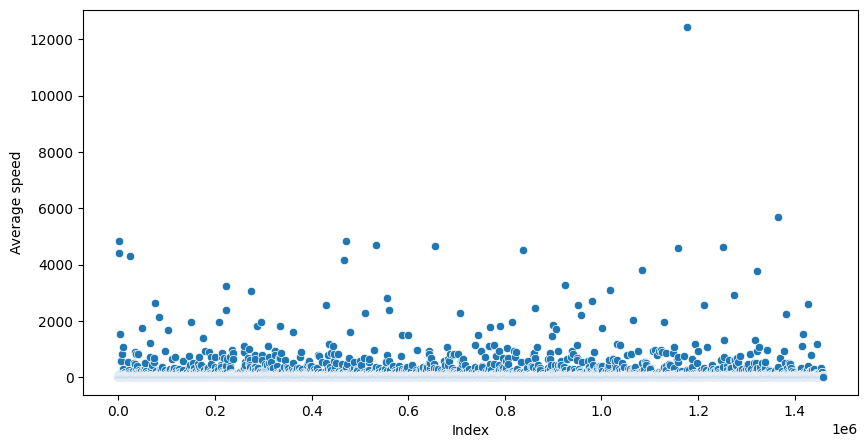

In [92]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


### Задание 2.11.
Найдем поездки, длительность которых превышает 24 часа. И удалим их из набора данных.

а) Узнаем сколько выбросов по признаку длительности поездки нам удалось найти

Найдем поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалим их из данных. 

б) Узнаем сколько выбросов по признаку скорости нам удалось найти

1

In [93]:

# Находим и удаляем поездки, длительность которых превышает 24 часа
outliers = taxi_data[taxi_data['trip_duration'] / 3600 > 24]
taxi_data = taxi_data[taxi_data['trip_duration'] / 3600 <= 24]

# Подсчитываем количество выбросов
outliers_count = len(outliers)

# Выводим результат
print(f'Количество выбросов по признаку длительности поездки: {outliers_count}')

Количество выбросов по признаку длительности поездки: 4


2

In [94]:

# Находим и удаляем поездки, средняя скорость которых превышает 300 км/ч
outliers_speed = taxi_data[(taxi_data['total_distance'] / 1000) / (taxi_data['trip_duration'] / 3600) > 300]
taxi_data = taxi_data[(taxi_data['total_distance'] / 1000) / (taxi_data['trip_duration'] / 3600) <= 300]

# Подсчитываем количество выбросов по признаку скорости
outliers_speed_count = len(outliers_speed)

# Выводим результат
print(f'Количество выбросов по признаку скорости: {outliers_speed_count}')


Количество выбросов по признаку скорости: 407


## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [95]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

### Задание 3.1.
Построим гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделаем предположение, является ли полученное распределение нормальным
Проверим свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

а) Узнаем Чему равен вычисленный p-value. Ответ округлим до сотых.

б) Узнаем Является ли распределение длительности поездок в логарифмическом масштабе нормальным

In [96]:
# формируем нулевую и альтернативную гипотезы для проверки данных на нормальность
H0 = 'Данные распределены нормально'
Ha = 'Распределение отлично от нормального'

#уровень значимости
alpha = 0.05

# тест Д'Агостино (возвращает двустороннюю вероятность для проверки гипотезы)
_, p = stats.normaltest(taxi_data['trip_duration_log'])
# Вывод результатов теста
print(f"Статистика теста: {_}")
print(f'P-value = {round(p, 2)}')

# интерпритация полученного результата
if p > alpha / 2: # p-value рассчитано для двусторонней гипотезы, поэтому уровень значимости делим на 2
    print(H0)
else:
    print(Ha)



Статистика теста: 138350.16605405
P-value = 0.0
Распределение отлично от нормального


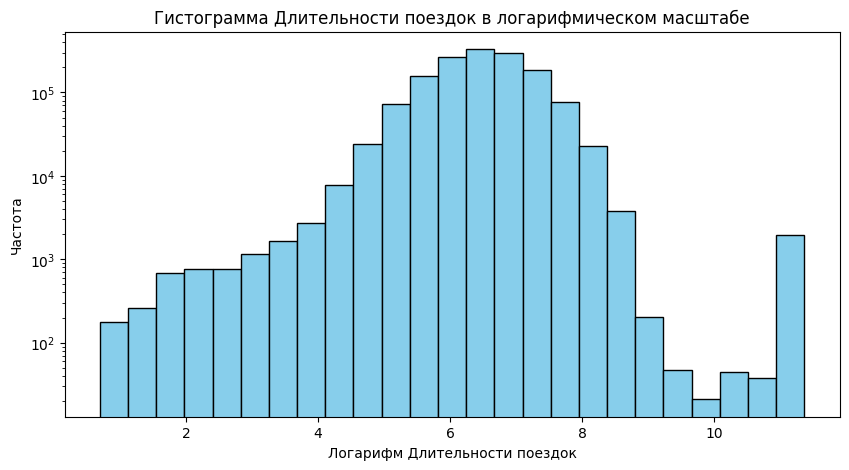

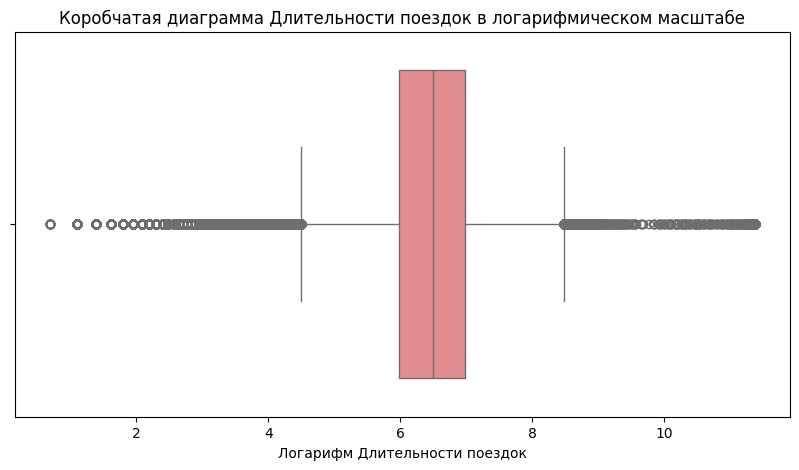

In [97]:
# Построение гистограммы в логарифмическом масштабе
plt.figure(figsize=(10, 5))
plt.hist(taxi_data['trip_duration_log'], bins=25, log=True, color='skyblue', edgecolor='black')
plt.xlabel('Логарифм Длительности поездок')
plt.ylabel('Частота')
plt.title('Гистограмма Длительности поездок в логарифмическом масштабе')

# Построение коробчатой диаграммы (ящик с усами) в логарифмическом масштабе
plt.figure(figsize=(10, 5))
sns.boxplot(x=taxi_data['trip_duration_log'], color='lightcoral')
plt.xlabel('Логарифм Длительности поездок')
plt.title('Коробчатая диаграмма Длительности поездок в логарифмическом масштабе')

plt.show()

### Задание 3.2.
Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравним два распределения между собой.

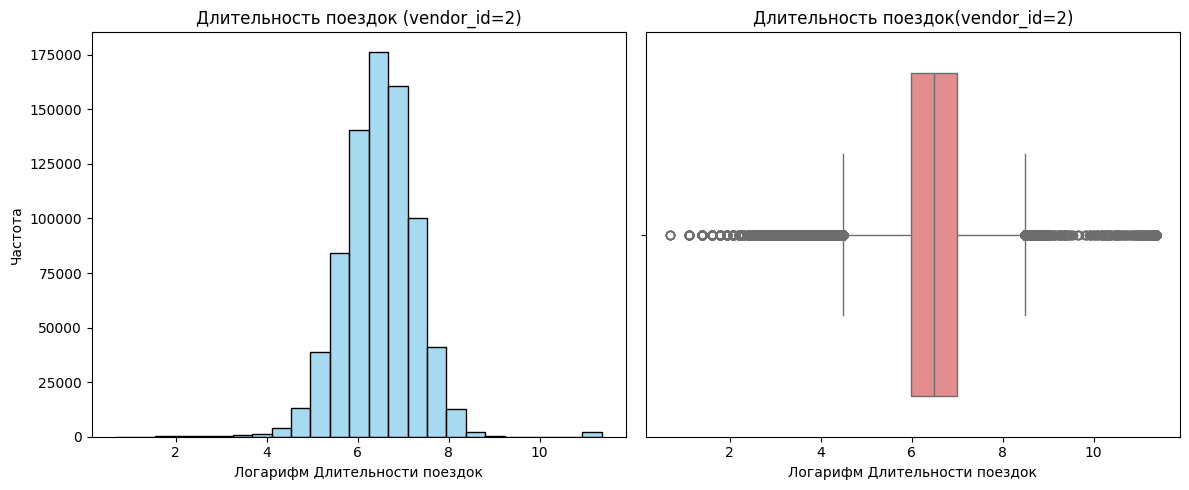

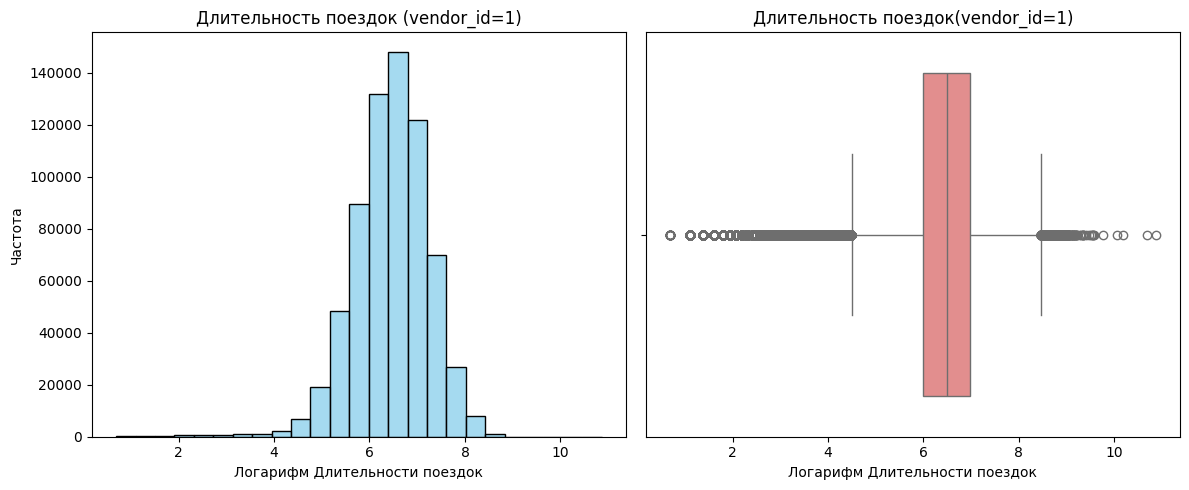

In [98]:
# Фильтруем данные по каждому таксопарку (vendor_id) и строим графики
for vendor_id in taxi_data['vendor_id'].unique():
    # Выбираем данные для текущего таксопарка
    data_subset = taxi_data[taxi_data['vendor_id'] == vendor_id]
    
    # Создаем два графика: гистограмму и коробчатую диаграмму
    plt.figure(figsize=(12, 5))
    
    # Гистограмма
    plt.subplot(1, 2, 1) 
    sns.histplot(data_subset['trip_duration_log'], bins=25, color='skyblue', edgecolor='black')
    plt.xlabel('Логарифм Длительности поездок')
    plt.ylabel('Частота')
    plt.title(f'Длительность поездок (vendor_id={vendor_id})')

    # Коробчатая диаграмма
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data_subset['trip_duration_log'], color='lightcoral')
    plt.xlabel('Логарифм Длительности поездок')
    plt.title(f'Длительность поездок(vendor_id={vendor_id})')

    plt.tight_layout()
    plt.show()

### Задание 3.3.
Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравним два распределения между собой.

/var/folders/05/hmpqd3711_dbrg0n41r_n5x80000gn/T/ipykernel_96441/3418348135.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




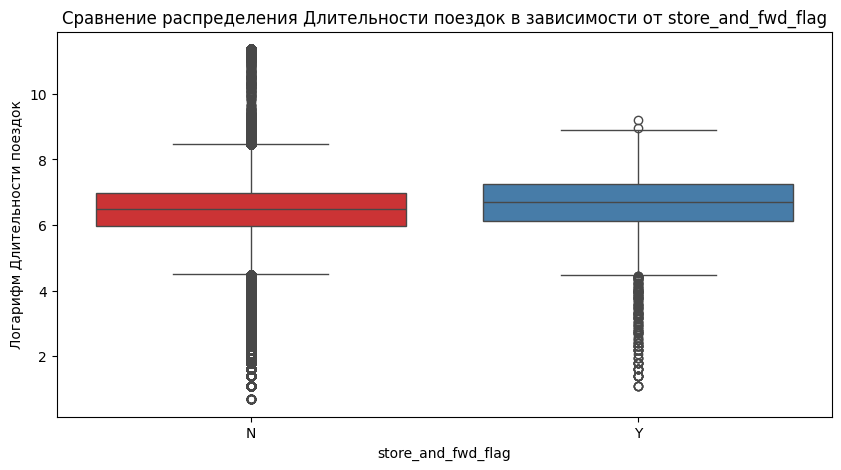

In [99]:
# Ящик с усами
plt.figure(figsize=(10, 5))
sns.boxplot(data=taxi_data, x='store_and_fwd_flag', y='trip_duration_log', palette='Set1')
plt.xlabel('store_and_fwd_flag')
plt.ylabel('Логарифм Длительности поездок')
plt.title('Сравнение распределения Длительности поездок в зависимости от store_and_fwd_flag')
plt.show()

### Задание 3.4.
Построим две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответим на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

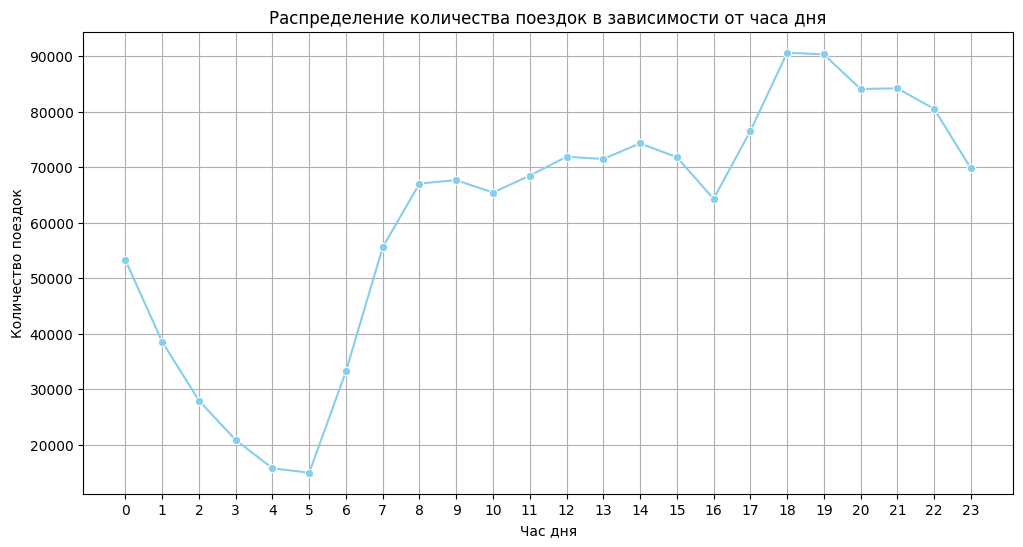

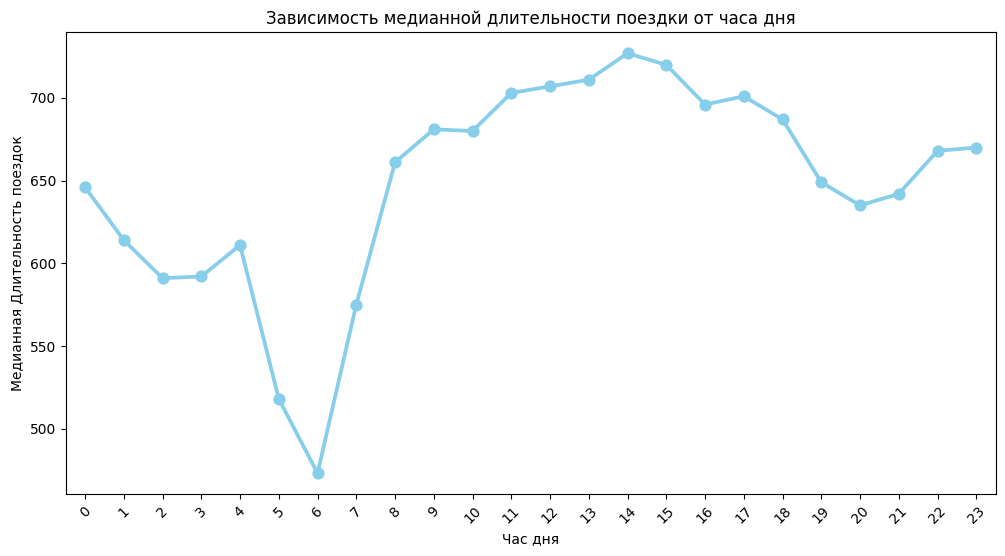

In [100]:
# Группируем данные по часу и считаем количество поездок в каждом часе
hourly_trip_counts = taxi_data.groupby('pickup_hour').size().reset_index(name='trip_count')

# Создаем линейный график
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_trip_counts, x='pickup_hour', y='trip_count', marker='o', color='skyblue')
plt.xlabel('Час дня')
plt.ylabel('Количество поездок')
plt.title('Распределение количества поездок в зависимости от часа дня')
plt.xticks(range(24))
plt.grid()
plt.show()

# Группируем данные по часу и вычисляем медианную длительность поездки в каждом часе
hourly_median_duration = taxi_data.groupby('pickup_hour')['trip_duration'].median().reset_index()

# Создаем точечный график
plt.figure(figsize=(12, 6))
sns.pointplot(data=hourly_median_duration, x='pickup_hour', y='trip_duration', color='skyblue')
plt.xlabel('Час дня')
plt.ylabel('Медианная Длительность поездок')
plt.title('Зависимость медианной длительности поездки от часа дня')
plt.xticks(rotation=45)
plt.show()


### Задание 3.5.
Построим две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


In [101]:
taxi_data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')

In [102]:
# Группируем данные по дню недели и считаем количество поездок в каждый день недели
daily_trip_counts = taxi_data.groupby('pickup_day_of_week').size().reset_index(name='trip_count')

# Создаем столбчатую диаграмму с Plotly
fig = px.bar(
    daily_trip_counts,
    x='pickup_day_of_week',
    y='trip_count',
    color='pickup_day_of_week',
    labels={'pickup_day_of_week': 'День недели', 'trip_count': 'Количество поездок'}
)
fig.update_layout(title='Распределение количества поездок в зависимости от дня недели', xaxis_tickangle=-45)
fig.show()

In [103]:
# Группируем данные по дню недели и вычисляем медианную длительность поездки в каждый день недели
daily_median_duration = taxi_data.groupby('pickup_day_of_week')['trip_duration'].median().reset_index()

# Создаем линейный график с Plotly
fig = px.line(
    daily_median_duration,
    x='pickup_day_of_week',
    y='trip_duration',
    labels={'day_of_week': 'День недели', 'trip_duration': 'Медианная длительность поездки'}
)
fig.update_traces(mode='lines+markers')
fig.update_layout(title='Зависимость медианной длительности поездки от дня недели', xaxis_tickangle=-45)
fig.show()


### Задание 3.6.
Посмотрим на обе временные характеристики одновременно. 

Построим сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируем полученную сводную таблицу с помощью тепловой карты.

pickup_day_of_week,0,1,2,3,4,5,6
pickup_hour,,,,,,,
0,598.0,591.0,601.0,609.0,649.0,685.0,675.0
1,567.0,584.0,553.0,564.0,600.0,640.0,643.0
2,565.0,565.0,544.0,576.0,572.0,610.0,604.5
3,600.0,568.0,574.0,584.0,578.0,591.0,608.0
4,640.0,600.5,616.0,595.0,634.0,610.0,598.5


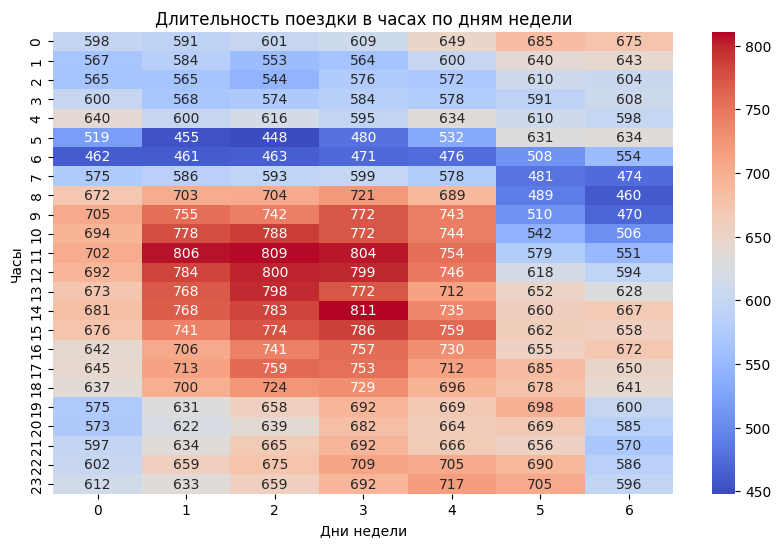

In [104]:
# создаём сводную таблицу
taxi_pivot = pd.pivot_table(
    data=taxi_data,
    values='trip_duration',
    index='pickup_hour',
    columns='pickup_day_of_week',
    aggfunc='median'
)

display(taxi_pivot.head())

fig = px.density_heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(taxi_pivot, annot=True, fmt='.0f', cmap='coolwarm')
plt.xlabel('Дни недели')
plt.ylabel('Часы')
plt.title('Длительность поездки в часах по дням недели')
plt.show()

### Задание 3.7.
Построим две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложим широту (longitude), а по оси ординат - долготу (latitude). 
Включим в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавим следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавим на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

Для наглядности уменьшим размер точек на диаграмме рассеяния.  


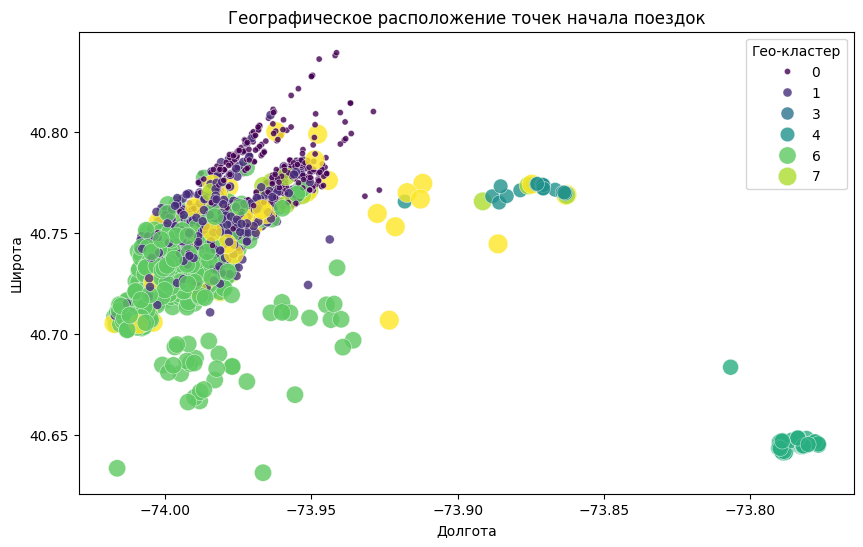

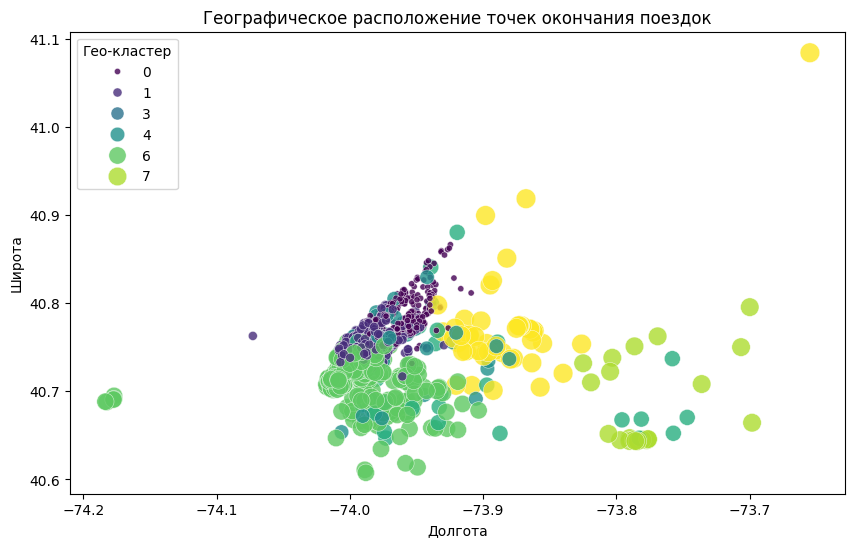

In [105]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# Фильтрация данных по границам города
filtered_data = taxi_data[(taxi_data['pickup_longitude'] >= city_long_border[0]) &
                          (taxi_data['pickup_longitude'] <= city_long_border[1]) &
                          (taxi_data['pickup_latitude'] >= city_lat_border[0]) &
                          (taxi_data['pickup_latitude'] <= city_lat_border[1])]

# Создание рассеянного графика для точек начала поездок
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_data.sample(n=2000), x='pickup_longitude', y='pickup_latitude', hue='geo_cluster',
                palette='viridis', alpha=0.8, size='geo_cluster', sizes=(20, 200))
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.title('Географическое расположение точек начала поездок')
plt.legend(title='Гео-кластер')
plt.show()

# Создание рассеянного графика для точек окончания поездок
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_data.sample(n=2000), x='dropoff_longitude', y='dropoff_latitude', hue='geo_cluster',
                palette='viridis', alpha=0.8, size='geo_cluster', sizes=(20, 200))
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.title('Географическое расположение точек окончания поездок')
plt.legend(title='Гео-кластер')
plt.show()

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [106]:
print(f'Shape of data: {taxi_data.shape}')
print(f'Columns: {taxi_data.columns}')

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [107]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,0,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,6,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,6,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,6,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,0,9.4,16.1,9.3,0.0,None,6.077642


### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

а) Выясним Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности

б) Утечка данных (data leak) - это ситуация, в которой данные используемые для обучения модели, содержат прямую или косвенную информацию о целевой переменной, но эти данные недоступны в реальных условиях.

в) Подумаем, наличие какого из признаков в обучающем наборе данных создает утечку данных

г) Исключим выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Узнаем сколько столбцов в таблице у нас осталось


In [108]:
# Удаление уникального признака 'id' и признака 'dropoff_datetime' (создающего утечку)
train_data = train_data.drop(['id', 'dropoff_datetime'], axis=1)

# Вывод количества столбцов в таблице после удаления
print(f"Количество столбцов после удаления: {len(train_data.columns)}")

Количество столбцов после удаления: 25


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [109]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print(f'Shape of data:  {train_data.shape}')

Shape of data:  (1458233, 23)


### Задание 4.2.

Закодируем признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируем признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

а) Рассчитаем среднее по закодированному столбцу vendor_id. Ответ приведем с точностью до сотых.

б) Рассчитаем среднее по закодированному столбцу store_and_fwd_flag. Ответ приведем с точностью до тысячных.



In [110]:
# Кодирование признака vendor_id
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)

# Кодирование признака store_and_fwd_flag
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

# Рассчитывание среднего по закодированному столбцу vendor_id_encoded
mean_vendor_id_encoded = round(train_data['vendor_id'].mean(), 2)

# Рассчитывание среднего по закодированному столбцу vendor_id_encoded
mean_store_and_fwd_flag_encoded = round(train_data['store_and_fwd_flag'].mean(), 3)

print(f"Среднее по закодированному столбцу vendor_id: {mean_vendor_id_encoded}")

print(f"Среднее по закодированному столбцу store_and_fwd_flag: {mean_store_and_fwd_flag_encoded}")



Среднее по закодированному столбцу vendor_id: 0.53
Среднее по закодированному столбцу store_and_fwd_flag: 0.006


### Задание 4.3.
Создадим таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEncoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В результате работы OneHotEncoder мы получим безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у нас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events. 


Узнаем сколько бинарных столбцов у нас получилось сгенерировать с помощью однократного кодирования


In [111]:

# Создаем экземпляр OneHotEncoder с параметром drop='first'
one_hot_encoder = OneHotEncoder(drop='first')

# Выбираем признаки для кодирования
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']

# Применяем кодировщик к выбранным признакам и получаем разреженную матрицу, переводим в массив 
data_onehot_sparse = one_hot_encoder.fit_transform(train_data[columns_to_change]).toarray()

# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)

# Преобразуем разреженную матрицу в numpy-массив
data_onehot = data_onehot_sparse

# Преобразуем результат в DataFrame
data_onehot = pd.DataFrame(data_onehot, columns=column_names)

display(data_onehot)

,pickup_day_of_week_1,pickup_day_of_week_2,pickup_day_of_week_3,pickup_day_of_week_4,pickup_day_of_week_5,pickup_day_of_week_6,geo_cluster_1,geo_cluster_2,geo_cluster_3,geo_cluster_4,geo_cluster_5,geo_cluster_6,geo_cluster_7,geo_cluster_8,geo_cluster_9,events_None,events_Rain,events_Snow
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458228,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1458229,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1458230,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1458231,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Добавим полученную таблицу с закодированными признаками:

In [112]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)
print(f'Shape of data: {train_data.shape}')

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [113]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [114]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберем 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуем по обучающей выборке, используя параметр score_func = f_regression.

Укажим признаки, которые вошли в список отобранных


In [115]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458233 entries, 0 to 1458232
Data columns (total 38 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   vendor_id             1458233 non-null  int64  
 1   passenger_count       1458233 non-null  int64  
 2   pickup_longitude      1458233 non-null  float64
 3   pickup_latitude       1458233 non-null  float64
 4   dropoff_longitude     1458233 non-null  float64
 5   dropoff_latitude      1458233 non-null  float64
 6   store_and_fwd_flag    1458233 non-null  int64  
 7   trip_duration         1458233 non-null  int64  
 8   pickup_hour           1458233 non-null  int64  
 9   pickup_holiday        1458233 non-null  int64  
 10  total_distance        1458233 non-null  float64
 11  total_travel_time     1458233 non-null  float64
 12  number_of_steps       1458233 non-null  float64
 13  haversine_distance    1458233 non-null  float64
 14  direction             1458233 non-

In [116]:

# Отбор признаков с помощью SelectKBest
selector = feature_selection.SelectKBest(
    score_func = feature_selection.f_regression,
    k = 25
)
selector.fit(X_train, y_train_log)

# Получение индексов выбранных признаков
best_features = selector.get_feature_names_out()
X_train = X_train[best_features]
X_valid = X_valid[best_features]

print('Признаки, которые вошли в список отобранных:', best_features)

Признаки, которые вошли в список отобранных: ['vendor_id' 'passenger_count' 'pickup_longitude' 'pickup_latitude'
 'dropoff_longitude' 'dropoff_latitude' 'store_and_fwd_flag' 'pickup_hour'
 'pickup_holiday' 'total_distance' 'total_travel_time' 'number_of_steps'
 'haversine_distance' 'temperature' 'pickup_day_of_week_1'
 'pickup_day_of_week_2' 'pickup_day_of_week_3' 'pickup_day_of_week_4'
 'pickup_day_of_week_5' 'pickup_day_of_week_6' 'geo_cluster_1'
 'geo_cluster_4' 'geo_cluster_5' 'geo_cluster_7' 'geo_cluster_8']


Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


### Задание 4.5.
Нормализуем предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помним, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитаем среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлим до сотых.


In [117]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458233 entries, 0 to 1458232
Data columns (total 38 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   vendor_id             1458233 non-null  int64  
 1   passenger_count       1458233 non-null  int64  
 2   pickup_longitude      1458233 non-null  float64
 3   pickup_latitude       1458233 non-null  float64
 4   dropoff_longitude     1458233 non-null  float64
 5   dropoff_latitude      1458233 non-null  float64
 6   store_and_fwd_flag    1458233 non-null  int64  
 7   trip_duration         1458233 non-null  int64  
 8   pickup_hour           1458233 non-null  int64  
 9   pickup_holiday        1458233 non-null  int64  
 10  total_distance        1458233 non-null  float64
 11  total_travel_time     1458233 non-null  float64
 12  number_of_steps       1458233 non-null  float64
 13  haversine_distance    1458233 non-null  float64
 14  direction             1458233 non-

In [118]:

# инициализируем нормализатор MinMaxScaler
scaler = preprocessing.MinMaxScaler()

# преобразовываем данные
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

print(f'Среднее арифметическое для первого предиктора из валидационной выборки: {np.mean(X_valid[:, 0]):.2f}')

# составляем DataFrame из массивов
X_train = pd.DataFrame(X_train, columns = best_features)
X_valid = pd.DataFrame(X_valid, columns = best_features)

Среднее арифметическое для первого предиктора из валидационной выборки: 0.54


## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



### Задание 5.1.
Построим модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используем в логарифмическом масштабе). Все параметры оставим по умолчанию.

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках. Ответ округлим до сотых.


In [119]:
# создаём объект класса LinearRegression
lr_model = linear_model.LinearRegression()

# обучаем модель и ищем параметры 
lr_model.fit(X_train, y_train_log)

# делаем предсказания
y_train_pred = lr_model.predict(X_train)
y_valid_pred = lr_model.predict(X_valid)

# рассчитываем RMSLE

print(f'RMSLE  на тренировочной выборке: {np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred)):.2f}')
print(f'RMSLE  на валидационной выборке: {np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred)):.2f}')

RMSLE  на тренировочной выборке: 0.53
RMSLE  на валидационной выборке: 0.54


### Задание 5.2.
Сгенерируем полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставим в значение False.

Построим модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используем в логарифмическом масштабе). Все параметры оставим по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлим до сотых.

б) Узнаем наблюдаются ли у вашей модели признаки переобучения


In [120]:

# создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree = 2, include_bias = False)
poly.fit(X_train)

# генерируем полиномиальные признаки
X_train_poly = poly.transform(X_train)
X_valid_poly = poly.transform(X_valid)

# строим модель полиномиальной регрессии
lr_poly = linear_model.LinearRegression()
lr_poly.fit(X_train_poly, y_train_log)
y_train_pred_poly = lr_poly.predict(X_train_poly)
y_valid_pred_poly = lr_poly.predict(X_valid_poly)

# рассчитываем RMSLE
print(f'RMSLE  на тренировочной выборке: {np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_poly)):.2f}')
print(f'RMSLE  на валидационной выборке: {np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_poly)):.2f}')

RMSLE  на тренировочной выборке: 0.47
RMSLE  на валидационной выборке: 0.61


### Задание 5.3.
Построим модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используем в логарифмическом масштабе). Коэффициент регуляризации $\alpha$ установим равным 1, остальные параметры оставим по умолчанию.

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках. Ответ округлим до сотых.


In [121]:

# Строим модель полиномиальной регрессии с L2-регуляризацией
ridge_model = linear_model.Ridge(alpha=1)  # Установка коэффициента регуляризации alpha=1
ridge_model.fit(X_train_poly, y_train_log)

# Прогноз на тренировочной и валидационной выборках
y_train_pred_r = ridge_model.predict(X_train_poly)
y_valid_pred_r = ridge_model.predict(X_valid_poly)

# Вычисление метрики RMSLE на тренировочной и валидационной выборках
rmsle_train_poly = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_r))
rmsle_valid_poly = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_r))

# Вывод метрики RMSLE, округленной до сотых
print(f"RMSLE на тренировочной выборке (полиномиальная регрессия с L2-регуляризацией): {rmsle_train_poly:.2f}")
print(f"RMSLE на валидационной выборке (полиномиальная регрессия с L2-регуляризацией): {rmsle_valid_poly:.2f}")


RMSLE на тренировочной выборке (полиномиальная регрессия с L2-регуляризацией): 0.48
RMSLE на валидационной выборке (полиномиальная регрессия с L2-регуляризацией): 0.48


### Задание 5.4.
Построим модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используем в логарифмическом масштабе). Все параметры оставим по умолчанию. 

а) Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках. Ответ округлим до сотых.

б) Узнаем Наблюдаются ли у нашей модели признаки переобучения


In [122]:


#Создаем объект класса дерево решений
dt = tree.DecisionTreeRegressor()
#Обучаем дерево по алгоритму CART
dt.fit(X_train, y_train_log)
#Выводим значения метрики 
y_train_pred_log = dt.predict(X_train)
y_valid_pred_log = dt.predict(X_valid)

# Вычисление метрики RMSLE на тренировочной и валидационной выборках
dt_rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_log))
dt_rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_log))

# Вывод метрики RMSLE, округленной до сотых
print(f"RMSLE на тренировочной выборке: {dt_rmsle_train:.2f}")
print(f"RMSLE на валидационной выборке: {dt_rmsle_valid:.2f}")


RMSLE на тренировочной выборке: 0.00
RMSLE на валидационной выборке: 0.57


### Задание 5.5.
Переберёмт все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Параметр random_state задайте равным 42.

Построим линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдем оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Узнаем чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной. Ответ округлим до сотых.


In [123]:
back_ff = train_data.copy()

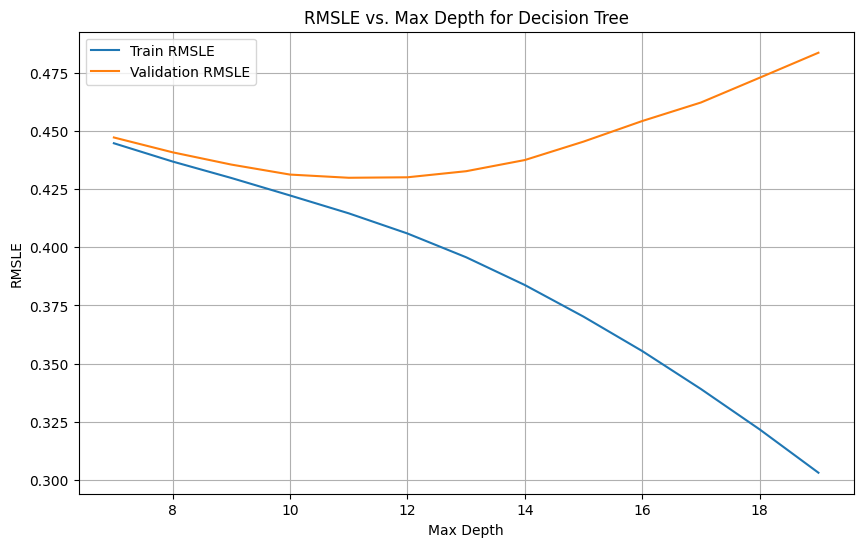

Оптимальная глубина дерева решений: 11
RMSLE  на тренировочной выборке: 0.41
RMSLE  на валидационной выборке: 0.43)


In [124]:
# Диапазон глубины дерева
max_depths = range(7, 20)

# Списки для хранения значений RMSLE
train_rmsle = []
valid_rmsle = []
# Перебор глубины дерева
for max_depth in max_depths:
    # Создание и обучение модели
    dt_new = tree.DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    #Обучаем дерево по алгоритму CART
    dt_new.fit(X_train, y_train_log)
    #Выводим значения метрики 
    y_train_pred = dt_new.predict(X_train)
    y_valid_pred = dt_new.predict(X_valid)
    
    train_rmsle.append(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred)))
    valid_rmsle.append(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred)))
    
# извлекаем индекс лучшего RMSLE на валидационной выборке
best_index = valid_rmsle.index(min(valid_rmsle))
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_rmsle, label='Train RMSLE')
plt.plot(max_depths, valid_rmsle, label='Validation RMSLE')
plt.xlabel('Max Depth')
plt.ylabel('RMSLE')
plt.legend()
plt.title('RMSLE vs. Max Depth for Decision Tree')
plt.grid(True)
plt.show()

print(f'Оптимальная глубина дерева решений: {max_depths[best_index]}')
print(f'RMSLE  на тренировочной выборке: {train_rmsle[best_index]:.2f}')
print(f'RMSLE  на валидационной выборке: {valid_rmsle[best_index]:.2f})')

## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### Задание 6.1.

Построим модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используем в логарифмическом масштабе). В качестве гиперпараметров укажим следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках. Ответ округлим до сотых.


In [125]:
rf = ensemble.RandomForestRegressor(
    n_estimators=200,
    criterion='squared_error',
    max_depth=12,
    min_samples_split=20,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train_log)
y_train_pred = rf.predict(X_train)
y_valid_pred= rf.predict(X_valid)

print(f'Train RMSLE {np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred)):.2f}')
print(f'Valid RMSLE {np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred)):.2f}')

Train RMSLE 0.40
Valid RMSLE 0.41


### Задание 6.2.
Построим модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используем в логарифмическом масштабе). В качестве гиперпараметров укажим следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках. Ответ округлим до сотых.


In [126]:
rf_gb  = ensemble.GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6,
    min_samples_split=30,
    random_state=42
    
)

rf_gb.fit(X_train, y_train_log)
y_train_pred = rf_gb.predict(X_train)
y_valid_pred= rf_gb.predict(X_valid)

print(f'Train RMSLE {np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred)):.2f}')
print(f'Valid RMSLE {np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred)):.2f}')


Train RMSLE 0.37
Valid RMSLE 0.39


### Задание 6.3.
Узнаем какая из построенных нами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


Из данных моделей наиболее лучший результат (Наименьшее значение) RMSLE на валидационной выборке показала модель Градиентного бустинга над деревьями решений.

### Задание 6.4.
Построим столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажим топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


Важность признаков в модели градиентного бустинга:
                 Признак  Важность
9         total_distance  0.627660
10     total_travel_time  0.188583
7            pickup_hour  0.059535
5       dropoff_latitude  0.027807
12    haversine_distance  0.025779
4      dropoff_longitude  0.012840
2       pickup_longitude  0.011489
3        pickup_latitude  0.010367
19  pickup_day_of_week_6  0.007353
11       number_of_steps  0.005590
13           temperature  0.004562
18  pickup_day_of_week_5  0.004546
0              vendor_id  0.004231
20         geo_cluster_1  0.002608
17  pickup_day_of_week_4  0.001552
16  pickup_day_of_week_3  0.001146
8         pickup_holiday  0.001008
15  pickup_day_of_week_2  0.000915
14  pickup_day_of_week_1  0.000903
1        passenger_count  0.000784
21         geo_cluster_4  0.000307
24         geo_cluster_8  0.000298
22         geo_cluster_5  0.000107
6     store_and_fwd_flag  0.000030
23         geo_cluster_7  0.000000


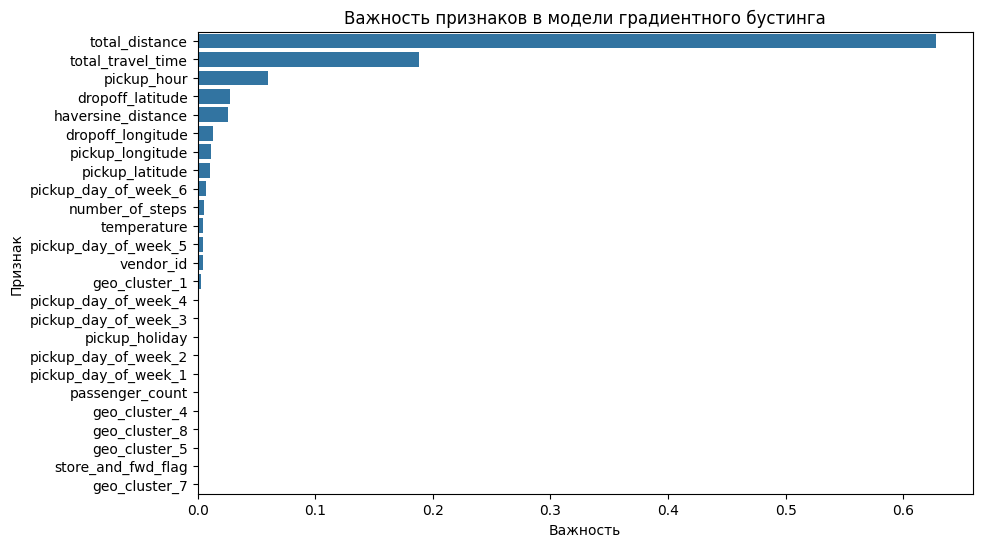

In [127]:
# Получение важности признаков из модели градиентного бустинга
importance = rf_gb.feature_importances_

# Создание DataFrame с признаками и их важностью
feature_importance_df = pd.DataFrame({'Признак': X_train.columns, 'Важность': importance})

# Сортировка по важности в убывающем порядке
feature_importance_df = feature_importance_df.sort_values(by='Важность', ascending=False)

# Вывод результатов
print("Важность признаков в модели градиентного бустинга:")
print(feature_importance_df)


# Создание графика важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Важность', y='Признак')
plt.title('Важность признаков в модели градиентного бустинга')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()

### Задание 6.5.
Для лучшей из построенных моделей рассчитаем медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведем в минуты и округлим до десятых.


In [128]:
absolute_errors = np.abs(np.exp(y_valid_log) - np.exp(y_valid_pred))

meae_minutes = np.median(absolute_errors) / 60

print(f"Медианная абсолютная ошибка MeAE: {meae_minutes:.1f}")


Медианная абсолютная ошибка MeAE: 1.8


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [129]:
test_data = pd.read_csv("data/test.csv")
osrm_data_test = pd.read_csv("data/osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [130]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[best_features]
X_test_scaled = scaler.transform(X_test)
print(f'Shape of data: {X_test.shape}')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Shape of data: (625134, 25)


Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Переведём предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как мы сформируем предсказание длительности поездок на тестовой выборке нам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [131]:
#предсказание для тестовой выборки
y_test_pred_log = rf_gb.predict(X_test_scaled)

# переводим предсказания из логарифмического маштаба 
y_test_predict = np.exp(y_test_pred_log) - 1

submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names



### **XGBoost**

В завершение по ансамблевым мы  попробуем улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

После чего модуль можно импортировать:

In [132]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [133]:
# Преобразовываем best_features  в список строк  
best_features = best_features.tolist()
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train_log, feature_names=best_features)
dvalid = xgb.DMatrix(X_valid, label=y_valid_log, feature_names=best_features)
dtest = xgb.DMatrix(X_test_scaled, feature_names=best_features)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [134]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:0.74154	valid-rmse:0.74355
[10]	train-rmse:0.49213	valid-rmse:0.49473
[20]	train-rmse:0.43984	valid-rmse:0.44268
[30]	train-rmse:0.42571	valid-rmse:0.42873
[40]	train-rmse:0.41836	valid-rmse:0.42157
[50]	train-rmse:0.41369	valid-rmse:0.41721
[60]	train-rmse:0.40938	valid-rmse:0.41324
[70]	train-rmse:0.40626	valid-rmse:0.41040
[80]	train-rmse:0.40391	valid-rmse:0.40835
[90]	train-rmse:0.40190	valid-rmse:0.40656
[100]	train-rmse:0.40003	valid-rmse:0.40498
[110]	train-rmse:0.39848	valid-rmse:0.40367
[120]	train-rmse:0.39752	valid-rmse:0.40298
[130]	train-rmse:0.39632	valid-rmse:0.40205
[140]	train-rmse:0.39538	valid-rmse:0.40141
[150]	train-rmse:0.39415	valid-rmse:0.40043
[160]	train-rmse:0.39293	valid-rmse:0.39946
[170]	train-rmse:0.39182	valid-rmse:0.39872
[180]	train-rmse:0.39103	valid-rmse:0.39811
[190]	train-rmse:0.39034	valid-rmse:0.39776
[200]	train-rmse:0.38967	valid-rmse:0.39741
[210]	train-rmse:0.38900	valid-rmse:0.39699
[220]	train-rmse:0.38823	valid-rmse:0.39661

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [135]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39430


In [137]:
submission_xgb = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission_xgb.to_csv('data/submission_xgb.csv', index=False)

Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

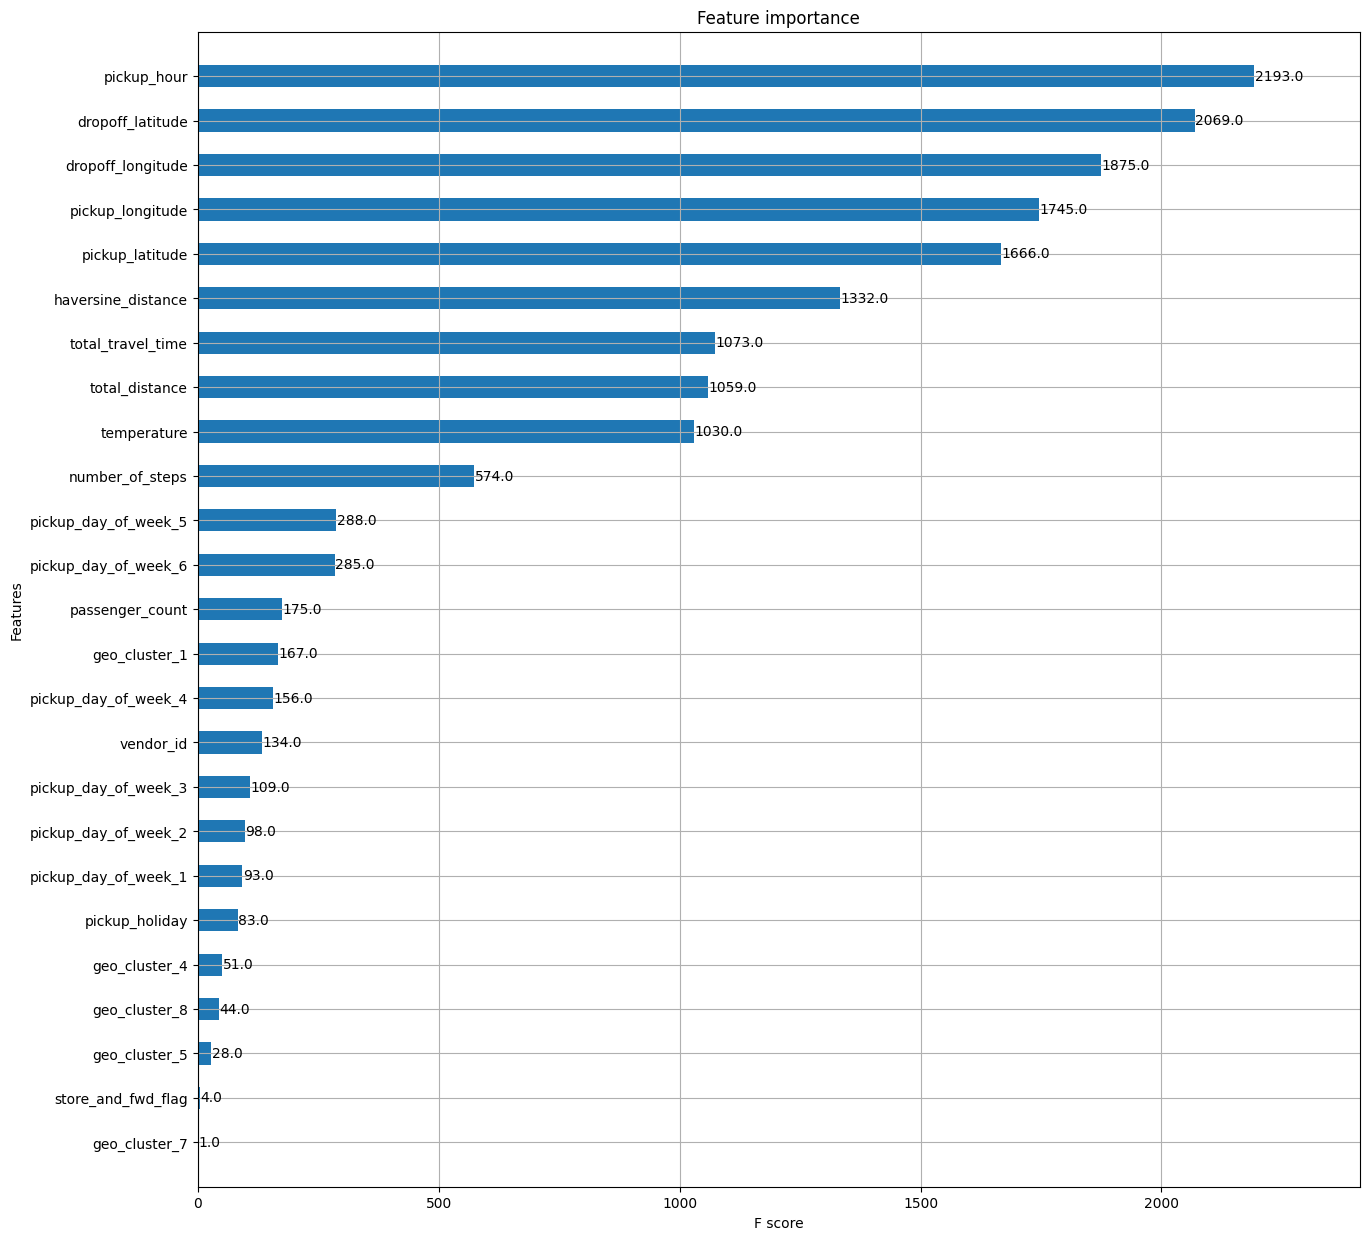

In [136]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)